# Building a model/process that can generate images of the digit eight

In [the lesson 9 video](https://youtu.be/_7rMfsA24Ls) of the FastAI course, Jeremy explains how diffusion models work at a very high level. (These initial videos were released to the public early on, though the rest of the course is still ongoing and thus hasn't yet been released.) Early on we're introduced to a basic algorithm which would work for generating images. In doing so, we are given a model for how to think about the diffusion process. This mental model itself reminds of how we train models in the standard machine learning workflow.

The process goes as follows:

1. train a model that outputs a probability of whether a particular image is an image of a handwritten '8' digit. (If one already exists, then use that, but let's assume that it doesn't).
2. create an image that is just random noise (dimensions should correspond to those of our target image).
3. calculate the derivatives for each pixel in that random noise image (with respect to the probability that the image is a handwritten '8'
4. update the pixels (i.e. subtract from them) by some weighted amount according to the values for the derivatives for those pixels.
5. iteratively do this a bunch of times and watch as our random noise image slowly turns into an image of a handwritten '8' digit.

On some level, the rest of the complexity around the actual Stable Diffusion models relate to things like being able to combine a text prompt with the image generation, or making the process of training the model more efficient and so on. But for now, I'm choosing to focus on the core process as described above.

My choice to do this centered around the digit '8' is arbitrary. We could as well have chosen something like 'images of a shoe' or whatever, but that potentially adds more complexity that could distract from the core process.

## 1: Training an '8' digit classifier

Training a model that can output the probability that a digit is a number eight is fairly trivial and is something that [the FastAI part 1 course](https://course.fast.ai) prepares you well to tackle, so I'll handle that first since it's a pre-requisite for everything that happens subsequently.

Needless to say, I'll use the MNIST dataset as my source of training data. Potentially I can use Fashion MNIST as a stretch goal later on, but I'll start with the digit '8' and see where we get.

In [5]:
!pip install -Uqq pip
!pip install timm fastai torch datasets rich -Uqq

In [15]:
from fastai.vision.all import *
import timm

torch.set_printoptions(precision=6, sci_mode=False)

In [7]:
# dataset patched together from the original MNIST dataset
path = Path("./mnist_8_or_not/training")
path.ls()

(#4) [Path('mnist_8_or_not/training/not_8'),Path('mnist_8_or_not/training/8'),Path('mnist_8_or_not/training/.ipynb_checkpoints'),Path('mnist_8_or_not/training/eight_classifier.pkl')]

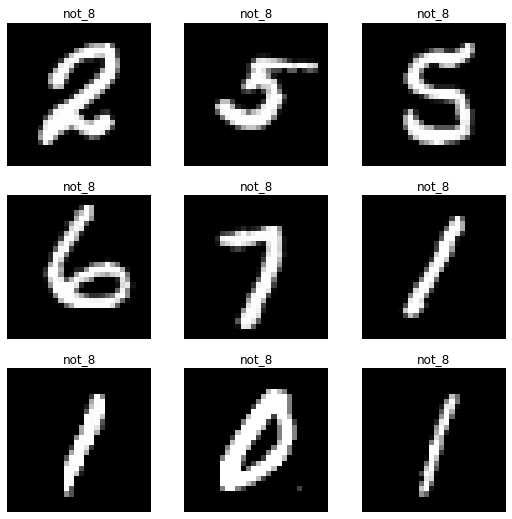

In [8]:
fnames = get_image_files(path)
def label_func(x): return x.parent.name

dls = ImageDataLoaders.from_path_func(path, fnames, label_func)
dls.show_batch()

As you can see, we now have a dataloader with images of handwritten eights and images of handwritten digits that are not eights. This data was taken from the MNIST dataset and reassembled for the purposes of making this model. (Heavy data class imbalance in favour of the not-eights, but putting that issue to one side for now).

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

# only train the model if we have no model already
model_path = Path("./eight_classifier.pkl")
if not model_path.exists():
    learn.fine_tune(5)
learn = load_learner("./eight_classifier.pkl")

In [74]:
an_eight = Path(path / "8").ls()[0]
not_an_eight = Path(path / "not_8").ls()[0]

In [11]:
learn.predict(an_eight), learn.predict(not_an_eight)

(('8', TensorBase(0), TensorBase([1.0000e+00, 5.5913e-07])),
 ('not_8', TensorBase(1), TensorBase([2.2082e-06, 1.0000e+00])))

Our model is pretty good at detecting whether digits are eights or not. I only trained it for five epochs, but it was already getting an error rate of almost zero. Good enough for the purposes of this proof-of-concept exploration.

In [12]:
from typing import Union

def get_eight_probability(image_pth: Union[Path, torch.Tensor], learner: Learner) -> torch.Tensor:
    _, _, probs = learner.predict(image_pth)
    return probs[0]

In [75]:
get_eight_probability(an_eight, learn)

TensorBase(0.995113)

In [76]:
get_eight_probability(not_an_eight, learn)

TensorBase(0.000268)

In [ ]:
# export our model so we don't have to retrain it every time from now on
if not model_path.exists():
    learn.export("eight_classifier.pkl")

In [18]:
loaded_learn = load_learner("./eight_classifier.pkl")
get_eight_probability(an_eight, loaded_learn)

TensorBase(0.999999)

## 2: Create a random noise image

So we have a way to get the probability that an image is an eight. Now we need to shift to the generation process, and we start by creating an image that is filled with random noise. We'll shift to raw PyTorch code here probably so that it's more explicit what's going on, and so our 'images' will be Tensors. Let's maybe make our images explicitly the same size as our training data, just to eliminate any confusion.

In [19]:
from PIL import Image

img = Image.open(an_eight)
width, height = img.size

print(f"Image dimensions: {width} x {height}")

Image dimensions: 28 x 28


Now we can generate a 28x28 image with random noise scattered throughout it.

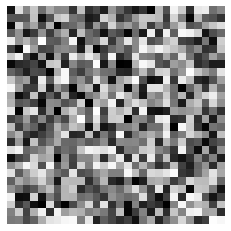

In [20]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Generate a 28x28 tensor filled with random noise
noise_tensor = torch.randn(1, 1, 28, 28)

# Convert the tensor to an image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1)
])
noise_image = transform(noise_tensor.squeeze())

# Display the image
plt.imshow(noise_image, cmap='gray')
plt.axis('off')
plt.show()


Let's turn that into a function so we can use it later on...

In [21]:
# we don't end up using this first function much as we're working with tensors
def get_noisy_starter_image() -> Image:
    # Generate a 28x28 tensor filled with random noise
    noise_tensor = torch.randn(1, 1, 28, 28)

    # Convert the tensor to an image
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1)
    ])
    return transform(noise_tensor.squeeze())

# we generate a 3x28x28 tensor with random values assigned
# we ensure that we can use PyTorch's autograd on the values
def get_noisy_starter_tensor() -> torch.Tensor:
    noise_tensor = torch.randn(1, 3, 28, 28, requires_grad = True)
    return noise_tensor

In [24]:
get_noisy_starter_image()

In [25]:
type(get_noisy_starter_tensor())

torch.Tensor

## 3: Get the derivatives for the probability that it's an eight

Our task now is go through the pixels of this 28x28 image and get the derivatives of each pixel with respect to the probability that the image is a digit '8'. We don't have to do this pixel by pixel (i.e. the 'finite differencing method') since we have PyTorch, so we can use 'analytic derivatives' to calculate the whole lot in a single sweep.

(Sidebar: I'm using those terms to reference two ways of calculating gradients from the universe of calculus, but I don't know anything really about what they signify or how they work. Just wanted to signal that I'm using them just because it came up in lesson 9 and it's often nice to have a name to put to a technique, even if you don't necessarily know how it works. If you don't know how it works too, welcome to the club and know that you don't always need to know everything at every moment :) )

In [82]:
random_sample = get_noisy_starter_tensor()

In [83]:
random_sample.shape

torch.Size([1, 3, 28, 28])

### Adding and updating our loss function

I experimented a bit with getting a loss function to do what I needed and it took several forms. I'm leaving the code here for posterity, but it doesn't get used anywhere else in this blog. The two helper functions are for displaying a tensor in the notebook, and for turning a tensor into an image that can be displayed.

In [26]:
#| code-fold: true
def new_eights_loss(preds: torch.Tensor, learner: Learner) -> torch.Tensor:
    targets = torch.Tensor([[1.0, 0]])
    return torch.nn.functional.mse_loss(preds, targets)

def display_tensor(tns: torch.Tensor) -> None:
    plt.imshow(tns, cmap='gray')
    plt.axis('off')
    plt.show()

def tns_to_img(tns: torch.Tensor) -> Image:
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1)
        ])
    return display_tensor(transform(tns.squeeze()))

## Automating the iterations

At this point we should just give it a try. In what follows, we get an image of something that isn't an eight, then iterate a number of times through the `iterate_image` function which:

- ensures that we're tracking and calculating the gradients on the image
- gets the predictions for our image (i.e. whether it's an eight or not) and passing them through a softmax
- we pass our predictions and our targets into a `l1_loss` function (i.e. the mean absolute error) to get the loss for these predictions.
- we call `backward()` on the loss so that the gradients are calculated
- we then update our image data by some constant times our gradients (just like we do in the normal ML training loop)
- we zero out the gradients prior to the next iteration

(Every 15 iterations we output the loss as well as the image at that particular moment.)

In [66]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [77]:
image = transform(Image.open(not_an_eight).convert("RGB"))
_ = image.requires_grad_()

In [97]:
import numpy as np

def iterate_image(image, iota: int, update_rate: float = 0.1):
    image.requires_grad_()
    preds = torch.softmax(loaded_learn.model(image[None]), dim=1)
    targets = torch.Tensor([[1.0, 0]])
    # loss = torch.nn.functional.mse_loss(preds, targets)
    loss = torch.nn.functional.l1_loss(preds, targets)
    loss.backward()
    if i % 15 == 0:
        print(f"grad_sum: {image.grad.data.sum()}, loss: {loss}")
    
    image.data -= (update_rate * image.grad.data)
    image.grad.zero_()
    
    if i % 15 == 0:
        # N.B. Use v1 to get a sense of what's changing, v2 for the current values
        
        # VERSION 1
        # plt.imshow(np.log1p(image[0].detach().numpy()))
        # plt.show(plt.gcf())
        
        # VERSION 2
        plt.imshow(image[0].detach().numpy())
        plt.show()

We iterate 50 times, and we our constant for the `update_rate` is fairly high (i.e. 1). Normally for a learning_rate (the equivalent for this value) we would choose something between 0.01 and 0.1 so as not to update too far in any one direction.

Also, just to confirm, these are our predictions for the `not_an_eight` image we're using as the basis for this iterative process:

In [96]:
learn = load_learner("./eight_classifier.pkl")
learn.predict(not_an_eight)

('not_8', TensorBase(1), TensorBase([    0.000268,     0.999732]))

grad_sum: -0.0006039840518496931, loss: 0.9997323155403137


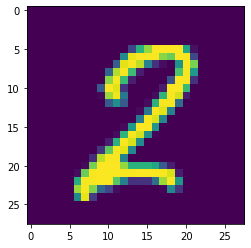

grad_sum: -0.003538962686434388, loss: 0.0007090563885867596


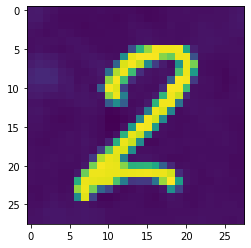

grad_sum: -0.0011799032799899578, loss: 0.00022288746549747884


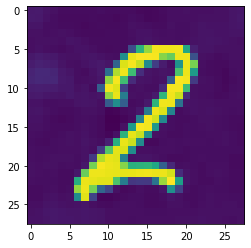

grad_sum: -0.0007250444614328444, loss: 0.00012537218572106212


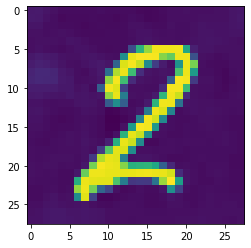

In [79]:
for i in range(50):
    iterate_image(image, i, update_rate = 1)

As you can see, the loss reduces throughout (and would continue to do so were I to let it continue onwards). The image still looks like a two, however, and doesn't seem to resemble an eight. So is it doing what we want? A quick check is to run that image we've updated / 'generated' into the model and get the predictions:

In [84]:
torch.sigmoid(loaded_learn.model(image[None]))

TensorBase([[0.989906, 0.010533]], grad_fn=<AliasBackward0>)

In [86]:
# double-checking using a freshly imported learner to make sure
learn = load_learner("./eight_classifier.pkl")
torch.sigmoid(learn.model(image[None]))

TensorBase([[0.989906, 0.010533]], grad_fn=<AliasBackward0>)

So even though the image still looks like a two, our model has been bamboozled into thinking it's an eight. The iteration process has updated the weights just enough that we've minimised our loss, and our model now is almost completely certain that this is an image of an eight.

I've tried the same process on the random noise and you don't get quite as impressive updating as quickly as with our two, but maybe with more iterations it would gradually get there.

Needless to say, this was a surprising result. I expected to have a neat progression through which the image would gradually look more and more like a number eight. This updating where we adjust enough to completely switch the predictions of the model from certainty that it isn't an eight, to certainty that it is an eight, that was unexpected to say the least.

*I'm really appreciative of the various people who helped me during the process of working on this little experiment: Yogya, Kevin, and all those with whom I have the pleasure to meet each week in the [Delft FastAI Study Group](https://www.meetup.com/delft-fast-ai-study-group/).*

## Appendix: Some PyTorch Things

I learned or encountered a lot of small PyTorch tricks while working on this, so making a note of them as a record for future reference:

- `autograd` - this is PyTorch's way of automatically calculating the gradients. I've never done this process manually myself, nor do I know how to do it, but I reckon this probably saves us a lot of time and complication.
- `squeeze()` and `unsqueeze()` - these remove and add a dimension to a tensor. It can help in getting things into the right shape.
- `view()` - maybe even more helpful when it comes to getting tensors in the right shape. I ran into lots of places where I was passing something of slightly the wrong shape or dimensions in somewhere and that was causing problems.
- `zero_()` - a way of zeroing out the gradients in-place
- `detach()` - this is a way of getting a copy of the current tensor, but one that isn't attached to the graph of gradient calculations that are going on.
- `requires_grad_()` - again, another way to ensure that a tensor has the gradient calculations enabled, and it happens in-place.
- `torch.equals(t1, t2)` - a way of comparing two tensors to see if they're identical or not.

I discovered that FastAI's `learn.predict()` function does some things to whatever you pass in, such that if you use it in the process above you'll hit an error where it says that there are no longer any gradients to update / accumulate. This is why we're passing our image values or our tensor directly into the model to get our predictions since this bypasses whatever FastAI is doing. I wasn't able to fully grok / dig into exactly what's happening there, but perhaps this is something to look into in the future.

### Debugging tips

On Saturday, I had basically a whole day of hitting lots of walls, somewhat-opaque PyTorch error messages galore. The thing that really seemed to help the most (and that my study group colleagues did with me on Sunday morning) was just to break out each individual step separately, inspecting the return values and the `.shape` and so on.

Doing this systematically, interrogating what you expect to happen vs what you see being returned or happening definetely seems like the way to go. At this level of (non-)abstraction, however, there were quite a few PyTorch messages that were hard to wrap my head around. I suppose when you do this often enough you get an intuition for the kinds of ways these things fail, and how to massage your data into the formats required.